In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt 

##sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay,confusion_matrix

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline

import python_files.functions_barcelona_2 as fb2

%load_ext autoreload
%autoreload 2

with open('./data/model_charac.pkl','rb') as file:
    model_dict=pickle.load(file)
model_dict


oversamplers=fb2.oversamplings
undersamplers=fb2.undersamplings
metric_dict=fb2.metrics
model_dict['models']=fb2.models_dict
model_dict['models']
# model_dict['metrics']=[{'recall':recall_score}]
model_dict['metrics']=metric_dict
num_features=[col[0] for col in model_dict['numerical_features'].items() if col[1]>1]
cat_features=[col[0] for col in model_dict['categorical_features'].items() if col[1]>1]
acc=pd.read_csv('./data/accidents_weather_eng_2023.csv')
X=acc[num_features +cat_features]
y=acc.target
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2024)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",drop='first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

In [ ]:
df_scores=pd.DataFrame()
for key in model_dict['models'].keys():
    #print(dicty['model'])
    pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier",model_dict['models'][key])])
    pipe.fit(X_train,y_train)
    preds=pipe.predict(X_test)
    for met in model_dict['metrics'].keys():
        if met !='precision':
        #print(key, model_dict['metrics'][met](y_test,preds))
            df_scores.loc[key,met]=model_dict['metrics'][met](y_test,preds)
        else:
            df_scores.loc[key,met]=precision_score(y_test,preds, zero_division=1)

#adding oversampling
df_scores_over=pd.DataFrame()
for key in model_dict['models'].keys():
    #print(dicty['model'])
    for resampler in oversamplers.keys():
        pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',oversamplers[resampler]),("classifier",model_dict['models'][key])])
        pipe.fit(X_train,y_train)
        preds=pipe.predict(X_test)
        print(key, resampler)
        for met in model_dict['metrics'].keys():
            if met !='precision':
            #print(key, model_dict['metrics'][met](y_test,preds))
                df_scores_over.loc[key+'_'+resampler,met]=model_dict['metrics'][met](y_test,preds)
            else:
                
                df_scores_over.loc[key+'_'+resampler,met]=precision_score(y_test,preds, zero_division=1)
    
df_scores_over

#adding undersampling
df_scores_under=pd.DataFrame()
for key in model_dict['models'].keys():
    #print(dicty['model'])
    for resampler in undersamplers.keys():
        pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',undersamplers[resampler]),("classifier",model_dict['models'][key])])
        pipe.fit(X_train,y_train)
        preds=pipe.predict(X_test)
        print(key, resampler)
        for met in model_dict['metrics'].keys():
            if met !='precision':
            #print(key, model_dict['metrics'][met](y_test,preds))
                df_scores_under.loc[key+'_'+resampler,met]=model_dict['metrics'][met](y_test,preds)
            else:
                
                df_scores_under.loc[key+'_'+resampler,met]=precision_score(y_test,preds, zero_division=1)


pd.concat([df_scores,df_scores_over,df_scores_under]).to_csv('df_results.csv')

In [2]:
results=pd.read_csv('df_results.csv',index_col=[0])
results[results.accuracy>0.7].sort_values('recall',ascending=False).head()
#logreg is the clear winner

,recall,precision,accuracy,roc_auc
logreg_OSS,0.709114,0.058024,0.700624,0.704758
logreg_ENN,0.706617,0.057773,0.700244,0.703347
logreg,0.706617,0.057808,0.700434,0.703445
logreg_ROS,0.701623,0.057494,0.700687,0.701143
logreg_ADASYN,0.690387,0.057353,0.704329,0.697539


In [3]:
num_features=[col[0] for col in model_dict['numerical_features'].items() if col[1]>1]
cat_features=[col[0] for col in model_dict['categorical_features'].items() if col[1]>1]

X=acc[num_features +cat_features]
y=acc.target
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2024)
model=LogisticRegression(random_state=2024,class_weight='balanced',max_iter=500,solver='newton-cholesky',penalty=None)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",drop='first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',undersamplers['OSS']),("classifier",model)])
pipe.fit(X_train,y_train)
preds=pipe.predict(X_test)
recall=recall_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall, accuracy

(0.7078651685393258, 0.7005604990658348)

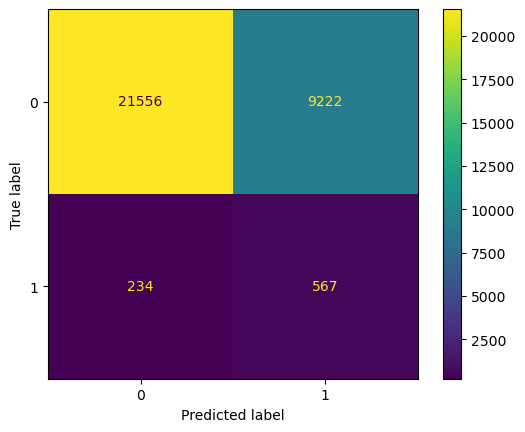

In [4]:
y_proba=pipe.predict_proba(X_test)
preds=pipe.predict(X_test)
prob_1=[p[1] for p in y_proba]
disp=ConfusionMatrixDisplay(confusion_matrix(y_test,preds))
disp.plot()

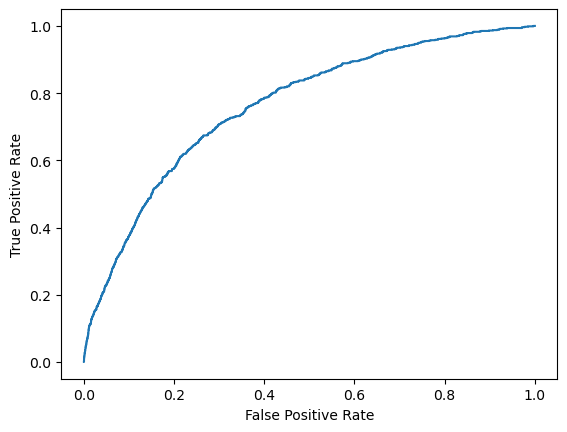

In [5]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test,prob_1)

In [ ]:
#Hypertunning
num_features=[col[0] for col in model_dict['numerical_features'].items() if col[1]>1]
cat_features=[col[0] for col in model_dict['categorical_features'].items() if col[1]>1]

X=acc[num_features +cat_features]
y=acc.target
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2024,stratify=y)
pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',undersamplers['OSS']),("classifier",LogisticRegression(random_state=2024,class_weight='balanced',max_iter=500))])
strat=StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=2024)
param_grid = [    
    {'classifier__penalty' : ['l1', 'l2', 'elasticnet', None],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['lbfgs','newton-cg','liblinear','sag','saga','newton-cholesky'],
    'classifier__max_iter' : [1000,2500]
    }
]
gs=RandomizedSearchCV(pipe,
               param_distributions=param_grid,
               scoring='roc_auc', #using roc_auc just to grab recall and accuracy
               cv=strat)
gs.fit(X_train,y_train)
with open('gs_model.pkl','wb') as file:
    pickle.dump(gs,file)
with open('best_model_bcn.pkl','wb') as f:
    pickle.dump(gs.best_estimator_.fit(X_train,y_train),f)

In [ ]:
##Checking if there is any overfitting

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",drop='first'))
    ]
)

accuracies=[]
recalls=[]
numerical_features=[col[0] for col in model_dict['numerical_features'].items() if col[1]>1]
categorical_features=[col[0] for col in model_dict['categorical_features'].items() if col[1]>1]

total_features=numerical_features+categorical_features
for num in range(1,len(total_features)):
    shift_recall=[]
    shift_accuracy=[]
    for tm in range(10):    
        choices=random.sample(total_features,k=num)
        
        num_features=[col for col in choices if col in numerical_features]
        cat_features=[col for col in choices if col in categorical_features]
        X_train,X_test,y_train,y_test=train_test_split(acc[choices],acc.target,random_state=2024,stratify=acc.target)
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_features),
                ("cat", categorical_transformer, cat_features),
            ]
        )
        
        

        pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',undersamplers['OSS']),("classifier",model_dict['models']['logreg'])])
        pipe.fit(X_train,y_train)
        preds=pipe.predict(X_test)
        shift_recall.append(recall_score(y_test,preds))
        shift_accuracy.append(accuracy_score(y_test,preds))
    print(num)
    accuracies.append(sum(shift_accuracy)/len(shift_accuracy))
    recalls.append(sum(shift_recall)/len(shift_recall))
        
recalls
##NO OVERFITTING because recall keeps improving as I add features while accuracy remains mostly the same

In [ ]:
##try with all features from selection
num_features=[col[0] for col in model_dict['numerical_features'].items()]
cat_features=[col[0] for col in model_dict['categorical_features'].items()]

X=acc[num_features +cat_features]
y=acc.target
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2024)
model=LogisticRegression(random_state=2024,class_weight='balanced',max_iter=500,solver='newton-cholesky',penalty=None)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",drop='first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

pipe = imbPipeline(
            steps=[("preprocessor", preprocessor),('resampler',undersamplers['OSS']),("classifier",model)])
pipe.fit(X_train,y_train)
preds=pipe.predict(X_test)
recall=recall_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall, accuracy
#Not enough again to compensate for the cost of adding them

In [ ]:
## trying keras
##changing threshold